# Data Source - `event_data.csv`

Исходные датасеты были импортированы в БД PostgreSQL (url- `luquuswuga.beget.app:5432`, доступ по запросу)

Для исследования был выбран датасет `event_data.csv` (хранилище лога событий)

С помощью запроса к таблице БД получены аггрегированные по месяцам данные и сохранены в файл `event_data_aggregation_202405282037.csv`.

Запрос к таблице `event_data` БД для получения аггрегированных данных:
```sql
-- Агрегирование событий клиентов по месяцам
select DATE_TRUNC('month', event_dtm_ts) AS month,  
	SUM(
		case 
			when currency = 'USD' then payout::numeric *96
			else payout::numeric
		end
	) AS total_payout_rub,
	event_type, 
	product_type,
	event_status,
	count(user_phone) user_id_cnt
FROM event_data
GROUP by  DATE_TRUNC('month', event_dtm_ts), event_type, product_type, event_status
ORDER BY month, event_type
;

```



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Загрузка данных из CSV файла
event = pd.read_csv('event_data_aggregation_202405282037.csv', delimiter=';')

# Преобразование столбца 'month' в datetime формат
event['month'] = pd.to_datetime(event['month'])
print(event.head())

       month  total_payout_rub  event_type product_type event_status  \
0 2023-02-01        1614730.40       click     deposits          NaN   
1 2023-02-01        3899051.72       click         loan          NaN   
2 2023-02-01         976006.28       click     mortgage          NaN   
3 2023-02-01         308895.60  conversion     deposits      approve   
4 2023-02-01         227974.80  conversion     deposits         deal   

   user_id_cnt  
0        33249  
1        79622  
2        20149  
3         1850  
4         3341  


# Поток пользователей (по месячно)

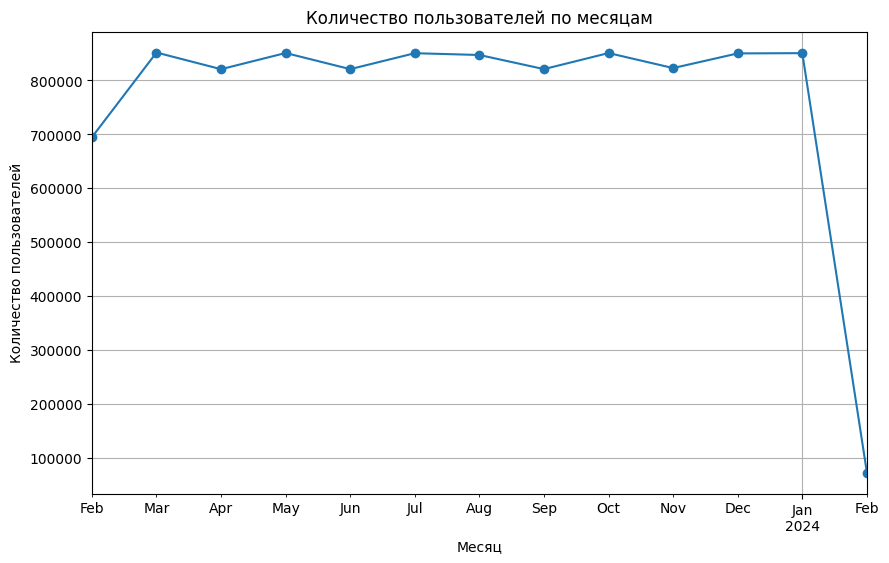

In [6]:
# Группировка данных по месяцам и суммирование количества  пользователей
monthly_users = event.groupby('month')['user_id_cnt'].sum()

# Построение графика
plt.figure(figsize=(10, 6))
monthly_users.plot(kind='line', marker='o')
plt.title('Количество пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

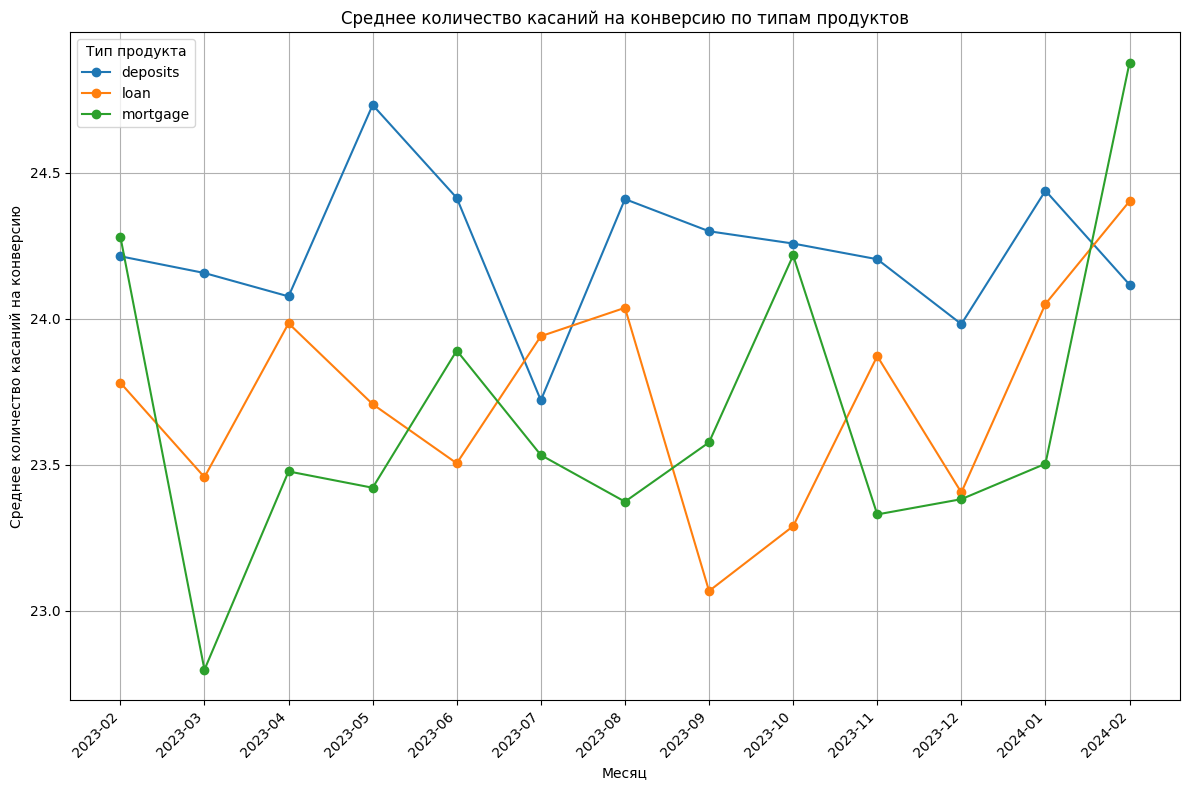

In [7]:
# Группировка по месяцам, типу продукта и типу события
event_grouped = event.groupby([event['month'].dt.to_period('M'), 'product_type', 'event_type'])['user_id_cnt'].sum().unstack().fillna(0)

# Подсчет общего количества касаний и количества конверсий за каждый месяц и тип продукта
event_grouped['total_touches'] = event_grouped.sum(axis=1)
event_grouped['total_conversions'] = event_grouped['conversion']

# Расчет среднего количества касаний на одну конверсию за каждый месяц и тип продукта
event_grouped['avg_touches_per_conversion'] = event_grouped['total_touches'] / event_grouped['total_conversions']

# Заполнение бесконечных значений нулями (если нет конверсий)
event_grouped['avg_touches_per_conversion'] = event_grouped['avg_touches_per_conversion'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Сброс уровня группировки для добавления столбца месяца
event_grouped_reset = event_grouped.reset_index()

# Преобразование месяца в строковый формат для отображения
event_grouped_reset['month'] = event_grouped_reset['month'].astype(str)

# Построение графика
plt.figure(figsize=(12, 8))

for product_type in event_grouped_reset['product_type'].unique():
    subset = event_grouped_reset[event_grouped_reset['product_type'] == product_type]
    plt.plot(subset['month'], subset['avg_touches_per_conversion'], marker='o', label=product_type)

# Добавление заголовков и меток
plt.title('Среднее количество касаний на конверсию по типам продуктов')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество касаний на конверсию')
plt.legend(title='Тип продукта')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
# Отображение графика
plt.tight_layout()
plt.show()

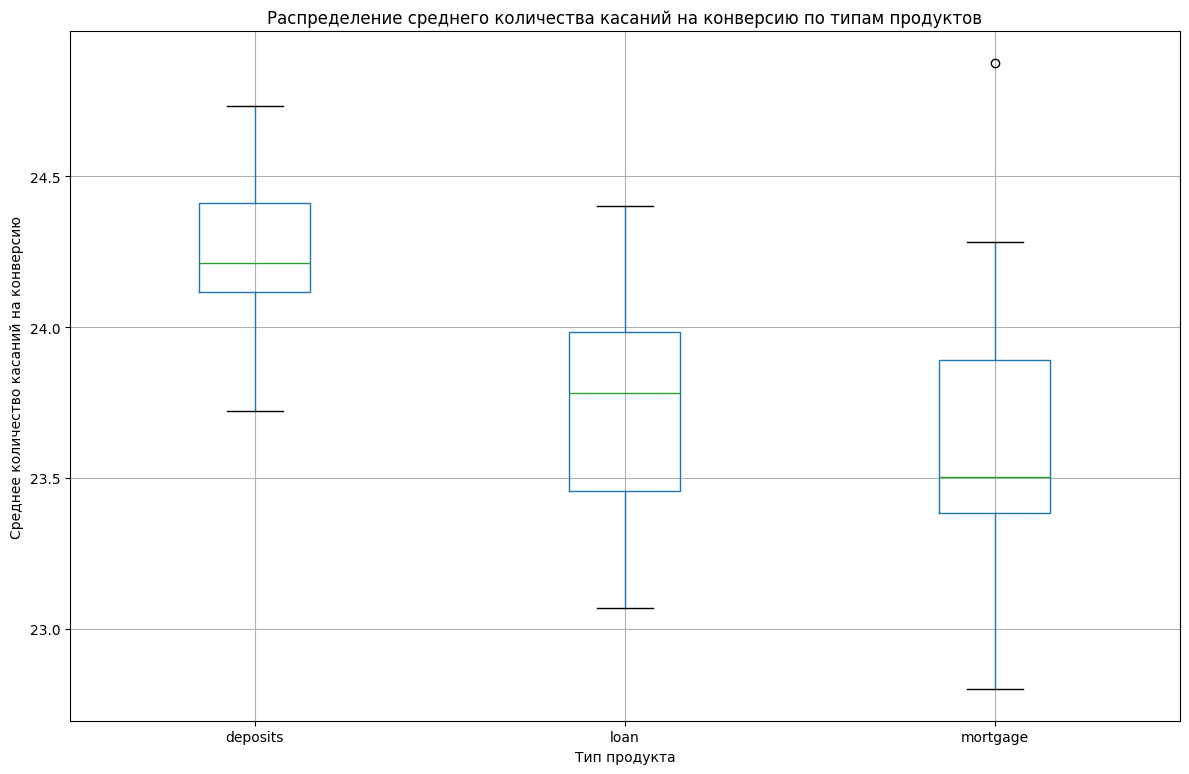

In [11]:
# Расчет описательных статистик
desc_stats = event_grouped_reset.groupby('product_type')['avg_touches_per_conversion'].describe()
# Построение графиков для визуализации описательных статистик
fig, ax = plt.subplots(figsize=(12, 8))

# Построение боксплотов (boxplot) для каждого типа продукта
event_grouped_reset.boxplot(column='avg_touches_per_conversion', by='product_type', ax=ax)

# Добавление заголовков и меток
plt.title('Распределение среднего количества касаний на конверсию по типам продуктов')
plt.suptitle('')  # Убираем автоматически добавляемый заголовок
plt.xlabel('Тип продукта')
plt.ylabel('Среднее количество касаний на конверсию')
plt.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

In [12]:
desc_stats

,count,mean,std,min,25%,50%,75%,max
product_type,,,,,,,,
deposits,13.0,24.232889,0.246867,23.720961,24.117260,24.214405,24.410310,24.732661
loan,13.0,23.731132,0.370317,23.067843,23.457788,23.781182,23.984687,24.402993
mortgage,13.0,23.666577,0.530793,22.798139,23.382331,23.503670,23.891447,24.877551


На основании графика, отображающего среднее количество касаний на конверсию по типам продуктов, можно предложить следующие модели атрибуции для каждого продукта:

### Анализ графика

1. **Deposits**:
   - График показывает, что для депозитов среднее количество касаний на конверсию стабильно выше, чем для других продуктов.
   - Рекомендованная модель атрибуции: **Linear Attribution** (Линейная атрибуция). Эта модель равномерно распределяет значение между всеми точками контакта. Она подойдет для депозитов, так как их конверсия зависит от постоянного взаимодействия клиента с продуктом на каждом этапе пути клиента.

2. **Loan**:
   - Среднее количество касаний для кредитов колеблется, но в целом не такое высокое, как для депозитов.
   - Рекомендованная модель атрибуции: **Last-Click Attribution** (Атрибуция последнего клика). Эта модель придаёт наибольший вес последнему взаимодействию перед конверсией. Для кредитов это может быть важно, так как финальное решение часто принимается после конкретного завершающего взаимодействия, такого как консультация или специальное предложение.

3. **Mortgage**:
   - График для ипотеки показывает значительные колебания в среднем количестве касаний на конверсию.
   - Рекомендованная модель атрибуции: **Time-Decay Attribution** (Атрибуция с учетом времени). Эта модель придаёт больший вес более поздним взаимодействиям, что может быть полезно для ипотек, где решение о покупке принимается постепенно, и последние взаимодействия (например, заключительные консультации или оценка недвижимости) являются критически важными.

### Рекомендации по моделям атрибуции

1. **Linear Attribution** для депозитов:
   - Учитывает все взаимодействия клиента с продуктом, что справедливо распределяет вклад каждого касания в конверсию.

2. **Last-Click Attribution** для кредитов:
   - Помогает понять, какое последнее взаимодействие непосредственно повлияло на принятие решения, что особенно важно для кредитных продуктов с быстрым циклом принятия решения.

3. **Time-Decay Attribution** для ипотеки:
   - Учитывает длительный цикл продаж ипотеки и придаёт больший вес последним шагам, которые наиболее влиятельны на принятие решения.

### Визуализация данных

График, подобный этому, помогает понять, как различаются клиентские пути для разных продуктов, и выбрать подходящую модель атрибуции для каждого из них. Он позволяет увидеть, где клиенты проводят больше времени и какие взаимодействия наиболее влиятельны для конверсии.